# Multi class coutnerfactual generation 

The notebook shows the progress of generating counterfactuals for a mutli class classification. It uses well known MNIST dataset, but any data would work. It would even be more appropriate to use some standard tabular data. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from mnist import MNIST  # (this uses mnist-py package)

from nn_model import NNModel
from counterfactual_generator import CounterfactualGenerator
from data import MixedEncoder

#### Prepare the data

In [2]:
mnist_data = MNIST()
model_path = "model_mnist_small.pt"

# take just every 10th pixel, I do not have license installed for big models right now
X_train = mnist_data.train_set.images[:, ::10]  
X_test = mnist_data.test_set.images[:, ::10]
# X_train = mnist_data.train_set.images  
# X_test = mnist_data.test_set.images
y_train = np.argmax(mnist_data.train_set.labels, axis=1)
y_test = np.argmax(mnist_data.test_set.labels, axis=1)

The counterfactual generator class expects an encoder 
and encoder expects a pandas dataframe, so we need to do this process.

It does not change the data inside, only understands if they are categorical, numerical or mixed.

In [3]:
mnist_df = pd.DataFrame(X_train)
mnist_df.columns = [f"Pixel {i*10 // 28}x{i*10 % 28}" for i in range(len(mnist_df.columns))]
encoder = MixedEncoder(mnist_df)
encoded = encoder.get_encoded_data()

#### Create Neural network
Create and train the Neural Net.

In [4]:
model = NNModel(encoded.shape[1], hidden_sizes=[30, 15], output_size=10)
to_train = False
if to_train:
    model.train(X_train, y_train, batch_size=128, epochs=50)
    model.save(model_path)
else:
    model.load(model_path)

In [5]:
print("Train data:")
model.test(X_train, y_train)
print()
print("Test data:")
model.test(X_test, y_test)

Train data:
Testing:
Accuracy: 91.43%
Average loss: 0.2666718018141866

Test data:
Testing:
Accuracy: 91.12%
Average loss: 0.2840216462547833


#### Select a datapoint
Prepare a datapoint for generating the "counterfactual"

In [6]:
selected_i = 0 # 0 to 9999
in_data = X_test[selected_i]

prediction = np.argmax(model.predict(encoder.encode_datapoint(in_data)))
print("Prediction:", prediction)
print("True target:", y_test[selected_i])

Prediction: 7
True target: 7


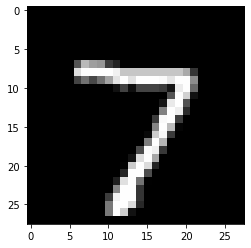

In [7]:
plt.imshow(mnist_data.test_set.images[selected_i].reshape((28, 28)), cmap="gray")

#### Generate the counterfactuals 

In [8]:
relative_distance_q = 0.1 # relative distance to optimum within which to search for 
cf_margin = 0.1 # margin represents the distance between best and second best class 

counter_class = (prediction + 5) % 10 # generate images with this class

In [9]:
cf_generator = CounterfactualGenerator(encoder)
counterfactuals = cf_generator.generate_close_counterfactuals(in_data, 
                                                              model,
                                                              relative_distance_q, 
                                                              goal_class=counter_class, 
                                                              n_limit=100, 
                                                              verbose=False, 
                                                              cf_margin=cf_margin)

Restricted license - for non-production use only - expires 2024-10-28


The generator generated 100 closest counterfactuals.
Showing only first 6


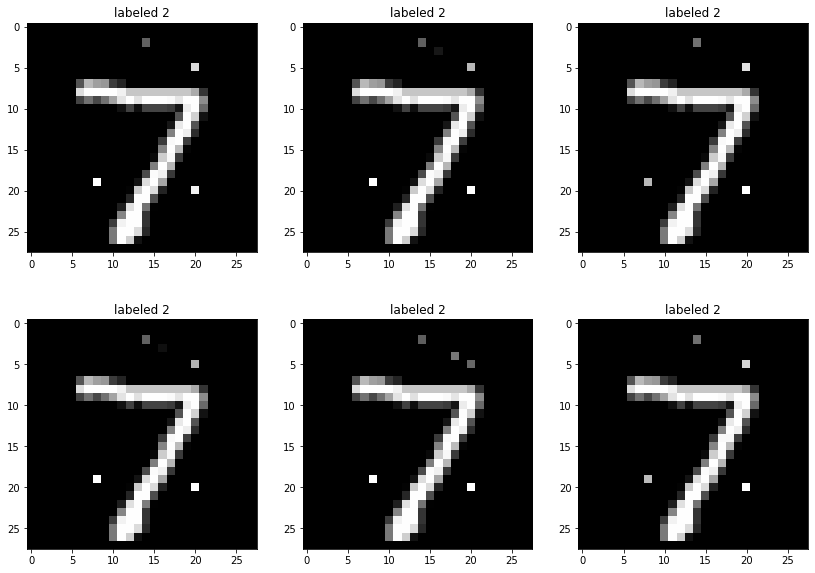

In [10]:
to_show = mnist_data.test_set.images[selected_i].copy()
show_n = 6

print(f"The generator generated {len(counterfactuals)} closest counterfactuals.")
if show_n < len(counterfactuals):
    print(f"Showing only first {show_n}")
    fig, axs = plt.subplots((show_n+1) // 3, 3, figsize=(14, 10))
else:
    fig, axs = plt.subplots((len(counterfactuals)+1) // 3, 3, figsize=(14, 10))
    
for cf, ax in zip(counterfactuals[:show_n], axs.flatten()):
    to_show[::10] = cf.counter_fact
    
    label = np.argmax(model.predict(cf.counter_fact.reshape(1, -1)))

    ax.imshow(to_show.reshape((28, 28)), cmap="gray")
    ax.set_title(f"labeled {label}")
plt.show()

Specific descriptions of the counterfactual changes: 

In [11]:
from textualizer import Textualizer

string_vals = {}
explainer = Textualizer(string_vals, encoder)

labels = [f"Number {i}" for i in range(10)]
for expl in explainer.formulate_list(counterfactuals[:show_n], labels):
    print(expl)


You got score Number 7.
One way you could have got score Number 2 instead is if:
  Pixel 2x14 had taken value 0.38 rather than 0.0 and 
  Pixel 5x20 had taken value 0.85 rather than 0.0 and 
  Pixel 19x8 had taken value 1.0 rather than 0.0 and 
  Pixel 20x20 had taken value 0.95 rather than 0.0
Another way you could have got score Number 2 instead is if:
  Pixel 2x14 had taken value 0.37 rather than 0.0 and 
  Pixel 3x16 had taken value 0.09 rather than 0.0 and 
  Pixel 5x20 had taken value 0.72 rather than 0.0 and 
  Pixel 19x8 had taken value 1.0 rather than 0.0 and 
  Pixel 20x20 had taken value 1.0 rather than 0.0
Another way you could have got score Number 2 instead is if:
  Pixel 2x14 had taken value 0.44 rather than 0.0 and 
  Pixel 5x20 had taken value 0.88 rather than 0.0 and 
  Pixel 19x8 had taken value 0.72 rather than 0.0 and 
  Pixel 20x20 had taken value 1.0 rather than 0.0
Another way you could have got score Number 2 instead is if:
  Pixel 2x14 had taken value 0.38 rat

### Generate image of any other class

In [12]:
# just by removing the goal_class parameter 
counterfactuals = cf_generator.generate_close_counterfactuals(in_data, 
                                                              model,
                                                              relative_distance_q, 
                                                              n_limit=100, 
                                                              verbose=False, 
                                                              cf_margin=cf_margin)

The generator generated 26 closest counterfactuals.
Showing only first 6


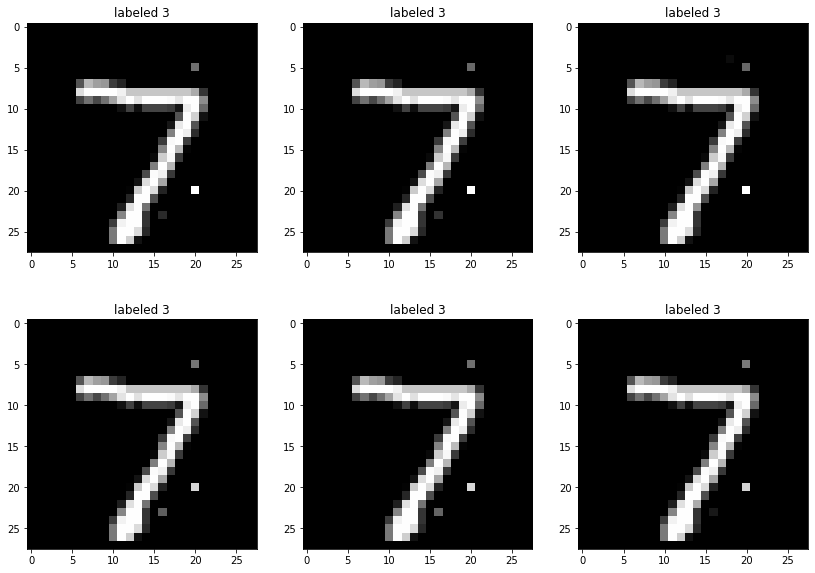

In [13]:
to_show = mnist_data.test_set.images[selected_i].copy()
show_n = 6

print(f"The generator generated {len(counterfactuals)} closest counterfactuals.")
if show_n < len(counterfactuals):
    print(f"Showing only first {show_n}")
    fig, axs = plt.subplots((show_n+1) // 3, 3, figsize=(14, 10))
else:
    fig, axs = plt.subplots((len(counterfactuals)+1) // 3, 3, figsize=(14, 10))
    
for cf, ax in zip(counterfactuals[:show_n], axs.flatten()):
    to_show[::10] = cf.counter_fact
    
    label = np.argmax(model.predict(cf.counter_fact.reshape(1, -1)))

    ax.imshow(to_show.reshape((28, 28)), cmap="gray")
    ax.set_title(f"labeled {label}")
plt.show()

Notice that there is less of them, even though we relaxed the conditions. This happens, because we seek solutionas within relative distance to optimum, so if this optimum is significantly lower, the previously found solutions are no longer searched. 

Indeed, because the relative distance quotient is low, we generate mostly countefactuals of the same kind.

In [14]:
print([cf.counter_class for cf in counterfactuals])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3]
